### Plot _thornado_ data

Notebook for quick plotting of 1D _thornado_ data for the limter parameter study. 

---

Action Items:
0. ~~Redo data structure: consider Python dictionary, `data['run']['field']`~~

1. ~~Compute and Plot Cell Averages~~
    
2. ~~Finish Runs~~ 

3. ~~Create Error Function~~

4. ~~Create Total Varaition Calculation~~

5. ~~Create Tables~~
   
6. ~~Add Componentwise to the plots below~~ 

7. ~~Shock Detector~~

8. ~~Plot Winner (2.0, 0.2) and reference like below.~~

9. Run with Other EOS's

10. Create another plotting file, plot: resolution comparison and EOS comparison.

---
To Do (Functional):  

* Make it easier to select what to plot. Currently: Very Manual 
* Want easier use for data from multiple runs
* Combine reading of data and creating data structures into one loop
---

In [1]:
import h5py    
import numpy as np  
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib ipympl

Some global plotting options

In [2]:
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['legend.handlelength']=4
mpl.rcParams['legend.fontsize']=14
mpl.rcParams['legend.frameon']=False
mpl.rcParams['axes.labelsize']=18
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['ytick.minor.visible']=True
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['xtick.labelsize']   = 14
mpl.rcParams['ytick.labelsize']   = 14

Data Directory. Simply change `simName` to the desired simulation. Later will likely have to modify.

In [51]:
eos = ["sfho_lowRes", "sfho_highRes", "sfhx", "dd2"]
fields = [ 'uAF_P', 'uAF_Ye', 'uPF_V1', 'uCF_D', 'uCF_Ne' ]
dataDirs = []#np.zeros( len(sims) )
for i in range( len( eos) ):
    dataDirs.append("../../data/Sod/nuclear/eos" + "/" + eos[i])
dataDir_ref = "../../data/Sod/nuclear/reference"

Setup figure directory

In [42]:
figDir = "../figures/"


For now, manually specify the `fileNumber`. Possibly add in ways to automatically get the max.

In [43]:
fileNumber = "000102"
#fileName = dataDir + '/' + simName + '_FluidFields_' + fileNumber + '.h5' 
fileNames = []#np.zeros(len(sims))
for i in range( len( eos) ):
    fileNames.append(dataDirs[i] + '/' + 'RiemannProblem' + '_FluidFields_' + fileNumber + '.h5' )
fileName_ref = dataDir_ref + '/' + 'RiemannProblem' + '_FluidFields_' + fileNumber + '.h5' 
mb = 1.660539 * pow(10,-24)

Read the Data and load into a python dict

In [44]:
data = {} # Point Values
for i in range( len( eos ) ):
    
    with h5py.File(fileNames[i], 'r') as f:
        
#         for key in f.keys():
#             print(key)

        time = f['Time'][:]

        x1d = f['/Spatial Grid/X1'][:]

        uAF_P  = f['/Fluid Fields/Auxiliary/Pressure'][:]
        uAF_Ye = f['/Fluid Fields/Auxiliary/Electron Fraction'][:]

        uPF_V1 = f['/Fluid Fields/Primitive/Three-Velocity (1)' ][:]

        uCF_D = f['/Fluid Fields/Conserved/Conserved Baryon Density'][:]
        uCF_Ne = f['/Fluid Fields/Conserved/Conserved Electron Density'][:]
        
        shock = f['/Shock Detector/Shock'][0][0][:]
        


        data[eos[i]] = {}
        data[eos[i]]['x1'] = x1d[:]
        data[eos[i]][fields[0]] = uAF_P[0][0][:]
        data[eos[i]][fields[1]] = mb * uCF_Ne[0][0][:] / uCF_D[0][0][:]#uAF_Ye[0][0][:]
        data[eos[i]][fields[2]] = uPF_V1[0][0][:]
        data[eos[i]][fields[3]] = uCF_D[0][0][:]
        data[eos[i]][fields[4]] = uCF_Ne[0][0][:]
#         for j in range(len(fields)):
#             data2[sims[i]][fields[j]] = 
    
## Reference Run    
with h5py.File(fileName_ref, 'r') as f:
    for key in f.keys():
        print(key)
    
    time = f['Time'][:]

    x1_ref = f['/Spatial Grid/X1'][:]
    
    uAF_P_ref  = f['/Fluid Fields/Auxiliary/Pressure'][:]
    uAF_Ye_ref = f['/Fluid Fields/Auxiliary/Electron Fraction'][:]

    uPF_V1_ref = f['/Fluid Fields/Primitive/Three-Velocity (1)' ][:]
    
    uCF_D_ref = f['/Fluid Fields/Conserved/Conserved Baryon Density'][:]
    uCF_Ne_ref = f['/Fluid Fields/Conserved/Conserved Electron Density'][:]
    
    print("Time:", float(time), "ms")
    
    


Fluid Fields
Shock Detector
Spatial Grid
Time
Time: 0.025 ms


Reference run

In [45]:
data_ref = {}
data_ref['x1'] = x1_ref
data_ref['uCF_D'] = uCF_D_ref[0][0][:]
data_ref['uAF_Ye'] = mb * uCF_Ne_ref[0][0][:] / uCF_D_ref[0][0][:] #uAF_Ye_ref[0][0][:]
data_ref['uCF_Ne'] = uCF_Ne_ref[0][0][:]
data_ref['uAF_P'] = uAF_P_ref[0][0][:]
data_ref['uPF_V1'] = uPF_V1_ref[0][0][:]

In [50]:
print(len(data[eos[0]]['x1']))
print(len(x1d))

300
100


Compute Cell Averages

Do this by summing over the pts in a cell (nNodes points per cell)

In [48]:
nNodes = 3
wG = [ 5.0/(1*18.0), 8.0/(1*18.0), 5.0/(1*18.0) ]
N_N = len(data[eos[0]]['x1'])

N_K = N_N / nNodes

#Make this nicer by creating a summation over len(fields)
data_avg = {}
for i in range( len( eos ) ):
    data_avg[eos[i]] = {}
    data_avg[eos[i]]['x1'] = np.zeros(int(N_K)) #Create arrays of length N_K
    data_avg[eos[i]][fields[0]] = np.zeros(int(N_K))
    data_avg[eos[i]][fields[1]] = np.zeros(int(N_K))
    data_avg[eos[i]][fields[2]] = np.zeros(int(N_K))
    data_avg[eos[i]][fields[3]] = np.zeros(int(N_K))
    data_avg[eos[i]][fields[4]] = np.zeros(int(N_K))
    for j in range(int(N_K)):
        data_avg[eos[i]]['x1'][j] = (np.sum( wG * data[eos[i]]['x1'][(j)*nNodes:(j+1)*nNodes] ))
        data_avg[eos[i]][fields[0]][j] = np.sum( wG * data[eos[i]][fields[0]][(j)*nNodes:(j+1)*nNodes] )
        data_avg[eos[i]][fields[1]][j] = np.sum( wG * data[eos[i]][fields[1]][(j)*nNodes:(j+1)*nNodes] )
        data_avg[eos[i]][fields[2]][j] = np.sum( wG * data[eos[i]][fields[2]][(j)*nNodes:(j+1)*nNodes] )
        data_avg[eos[i]][fields[3]][j] = np.sum( wG * data[eos[i]][fields[3]][(j)*nNodes:(j+1)*nNodes] )
        data_avg[eos[i]][fields[4]][j] = np.sum( wG * data[eos[i]][fields[4]][(j)*nNodes:(j+1)*nNodes] )
        
     

ValueError: operands could not be broadcast together with shapes (3,) (0,) 

SFHo: Low vs High Res

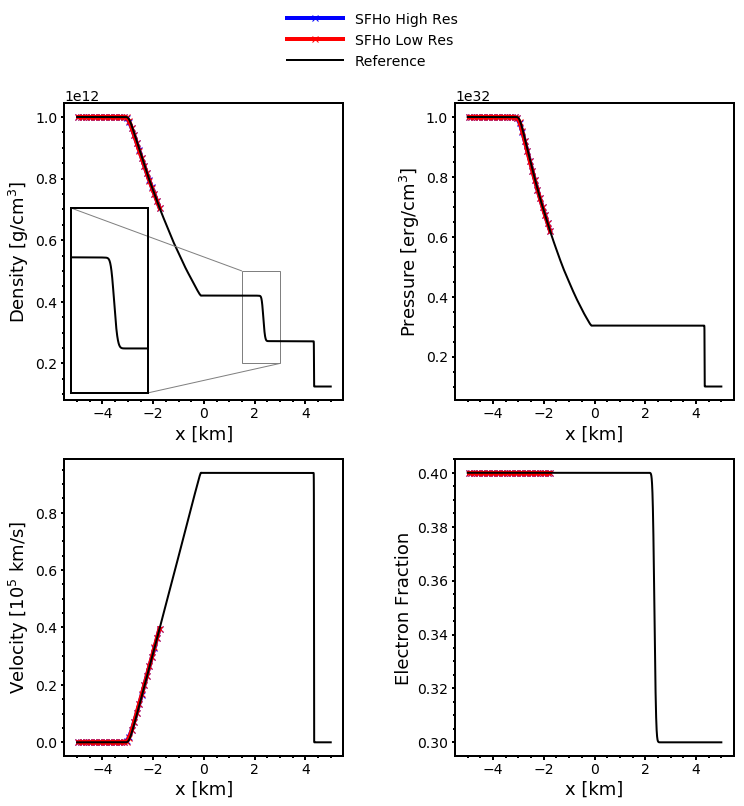

In [47]:
fig, cax = plt.subplots(2,2, sharex=False,figsize=(12,12))
fig.subplots_adjust(hspace=.2, wspace=0.4)
# ---
cax[0,0].plot(data_avg[eos[0]]['x1'],data_avg[eos[0]]['uCF_D'],marker='x',color='blue',label=r"SFHo High Res")
cax[0,0].plot(data_avg[eos[1]]['x1'],data_avg[eos[1]]['uCF_D'],marker='x',color='red',label=r"SFHo Low Res")
cax[0,0].plot(x1_ref,data_ref['uCF_D'], linestyle='-',linewidth='2.0', label="Reference", color = "black")
cax[0,0].set(xlabel="x [km]",ylabel = r'Density [g/cm$^3$]')
#cax[0,0].set_title("Sod Shock Tube (t = 0.025ms)")
# ---

cax[0,1].plot(data_avg[eos[0]]['x1'],data_avg[eos[0]]['uAF_P'],marker='x',color='blue',label=r"SFHo High Res")
cax[0,1].plot(data_avg[eos[1]]['x1'],data_avg[eos[1]]['uAF_P'],marker='x',color='red',label=r"SFHo Low Res")
cax[0,1].plot(x1_ref,data_ref['uAF_P'], linestyle='-',linewidth='2.0', label="Reference", color = "black")
cax[0,1].set(xlabel="x [km]",ylabel = r'Pressure [erg/cm$^3$]')
# --- 
# generate 2 2d grids for the x & y bounds

cax[1,0].plot(data_avg[eos[0]]['x1'],data_avg[eos[0]]['uPF_V1']/(10**5),marker='x',color='blue',label=r"SFHo High Res")
cax[1,0].plot(data_avg[eos[1]]['x1'],data_avg[eos[1]]['uPF_V1']/(10**5),marker='x',color='red',label=r"SFHo Low Res")
cax[1,0].plot(x1_ref,data_ref['uPF_V1']/(10**5), linestyle='-',linewidth='2.0', label="Reference", color = "black")
cax[1,0].set(xlabel="x [km]",ylabel = r'Velocity [$10^{5}$ km/s]')
# ---
cax[1,1].plot(data_avg[eos[0]]['x1'],data_avg[eos[0]]['uAF_Ye'],marker='x',color='blue',label=r"SFHo High Res")
cax[1,1].plot(data_avg[eos[1]]['x1'],data_avg[eos[1]]['uAF_Ye'],marker='x',color='red',label=r"SFHo Low Res")
cax[1,1].plot(x1_ref,data_ref['uAF_Ye'], linestyle='-',linewidth='2.0', label="Reference", color = "black")
cax[1,1].set(xlabel="x [km]",ylabel = r'Electron Fraction')
#cax[1,1].yaxis.tick_right()
#cax[1,1].yaxis.set_label_position("right")

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
axins = zoomed_inset_axes(cax[0,0], 2.0, loc=3) # zoom-factor: 2.5, location: upper-left
axins.plot(data_avg[eos[0]]['x1'],data_avg[eos[0]]['uCF_D'],marker='x',color='blue',label=r"SFHo High Res")
axins.plot(data_avg[eos[1]]['x1'],data_avg[eos[1]]['uCF_D'],marker='x',color='red',label=r"SFHo Low Res")
axins.plot(x1_ref,data_ref['uCF_D'], linestyle='-',linewidth='2.0', label="Reference", color = "black")
x1, x2, y1, y2 = 1.5, 3, 0.2*10**12, 0.5*10**12 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(cax[0,0], axins, loc1=2, loc2=4, fc="none", ec="0.5")
#$\beta_{TVD} = 2.0, C_{TCI}=0.2$

handles, labels = cax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')

#plt.savefig('../figures/eos_res.png', dpi=200, bbox_inches='tight')

All EOS

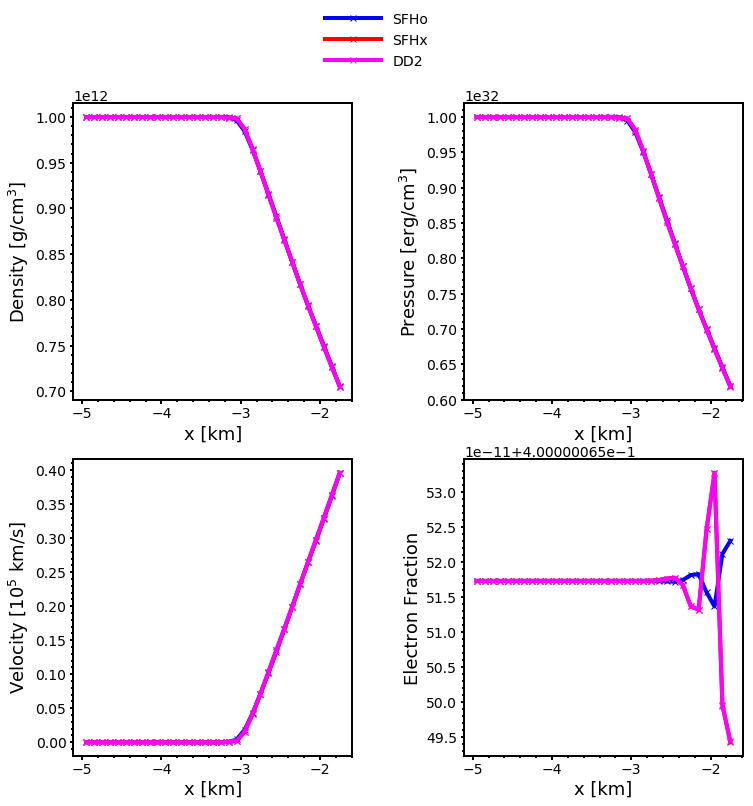

In [14]:
fig, cax = plt.subplots(2,2, sharex=False,figsize=(12,12))
fig.subplots_adjust(hspace=.2, wspace=0.4)
# ---
cax[0,0].plot(data_avg[eos[0]]['x1'],data_avg[eos[0]]['uCF_D'],marker='x',color='blue',label=r"SFHo")
cax[0,0].plot(data_avg[eos[2]]['x1'],data_avg[eos[2]]['uCF_D'],marker='x',color='red',label=r"SFHx")
cax[0,0].plot(data_avg[eos[3]]['x1'],data_avg[eos[3]]['uCF_D'],marker='x',color='magenta',label=r"DD2")
cax[0,0].set(xlabel="x [km]",ylabel = r'Density [g/cm$^3$]')
#cax[0,0].set_title("Sod Shock Tube (t = 0.025ms)")
# ---

cax[0,1].plot(data_avg[eos[0]]['x1'],data_avg[eos[0]]['uAF_P'],marker='x',color='blue',label=r"SFHo")
cax[0,1].plot(data_avg[eos[2]]['x1'],data_avg[eos[2]]['uAF_P'],marker='x',color='red',label=r"SFHx")
cax[0,1].plot(data_avg[eos[3]]['x1'],data_avg[eos[3]]['uAF_P'],marker='x',color='magenta',label=r"DD2")
cax[0,1].set(xlabel="x [km]",ylabel = r'Pressure [erg/cm$^3$]')
# --- 
# generate 2 2d grids for the x & y bounds

cax[1,0].plot(data_avg[eos[0]]['x1'],data_avg[eos[0]]['uPF_V1']/(10**5),marker='x',color='blue',label=r"SFHo")
cax[1,0].plot(data_avg[eos[2]]['x1'],data_avg[eos[2]]['uPF_V1']/(10**5),marker='x',color='red',label=r"SFHx")
cax[1,0].plot(data_avg[eos[3]]['x1'],data_avg[eos[3]]['uPF_V1']/(10**5),marker='x',color='magenta',label=r"DD2")
cax[1,0].set(xlabel="x [km]",ylabel = r'Velocity [$10^{5}$ km/s]')
# ---
cax[1,1].plot(data_avg[eos[0]]['x1'],data_avg[eos[0]]['uAF_Ye'],marker='x',color='blue',label=r"SFHo")
cax[1,1].plot(data_avg[eos[2]]['x1'],data_avg[eos[2]]['uAF_Ye'],marker='x',color='red',label=r"SFHx")
cax[1,1].plot(data_avg[eos[3]]['x1'],data_avg[eos[3]]['uAF_Ye'],marker='x',color='magenta',label=r"DD2")
cax[1,1].set(xlabel="x [km]",ylabel = r'Electron Fraction')
#cax[1,1].yaxis.tick_right()
#cax[1,1].yaxis.set_label_position("right")

# from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
# axins = zoomed_inset_axes(cax[0,0], 2.0, loc=3) # zoom-factor: 2.5, location: upper-left
# axins.plot(data_avg[eos[0]]['x1'],data_avg[eos[0]]['uCF_D'],marker='x',color='blue',label=r"SFHo")
# axins.plot(data_avg[eos[2]]['x1'],data_avg[eos[2]]['uCF_D'],marker='x',color='red',label=r"SFHx")
# axins.plot(data_avg[eos[3]]['x1'],data_avg[eos[3]]['uCF_D'],marker='x',color='magenta',label=r"DD2")
# x1, x2, y1, y2 = 1.5, 3, 0.2*10**12, 0.5*10**12 # specify the limits
# axins.set_xlim(x1, x2) # apply the x-limits
# axins.set_ylim(y1, y2) # apply the y-limits

# axins.xaxis.set_visible(False)
# axins.yaxis.set_visible(False)

# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# mark_inset(cax[0,0], axins, loc1=2, loc2=4, fc="none", ec="0.5")


handles, labels = cax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')

#plt.savefig('../figures/eos_all.png', dpi=200, bbox_inches='tight')

In [35]:
for i in range(len(eos)):
    print(np.max( data[eos[i]['x1']] ))

TypeError: string indices must be integers